In [48]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl
import seaborn as sns
import shap

from biobank_olink.constants import PROJECT_DATA

nb_data = PROJECT_DATA / "olink"

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# from tqdm import tqdm
# import numpy as np

# olink_xlsx = nb_data / "Olink population_ASI_only.xlsx"
# sheet_names = pd.ExcelFile(olink_xlsx).sheet_names
# 
# chunk_num = 4
# for i, sheet_split in tqdm(enumerate(np.array_split(sheet_names, chunk_num)), total=chunk_num):
#     dfs = pl.read_excel(olink_xlsx, sheet_name=list(sheet_split),
#                         infer_schema_length=1_000_000)
#     pl.concat(dfs.values()).write_parquet(nb_data / f"olink_population_ASI_only_{i}.parquet")
#     del dfs
# 

In [56]:
index_cols = ["sex", "age", "BMI", "Smokinstatus", "HTNgroup", "ASI"]
cols = ["protein_id", "result"] + index_cols

coding = pl.read_csv(nb_data / "coding143.tsv", separator="\t").with_columns(
    pl.col("meaning").str.split(";").list.get(0).alias("meaning"),
)
df = (
    pl.scan_parquet(nb_data / "olink_population_ASI_only_*.parquet")
    .select(cols)
    .filter(pl.col("ASI").is_not_null(), pl.col("HTNgroup") != 2)
    .with_columns(
        pl.col("protein_id").replace_strict(
            coding["coding"], coding["meaning"], return_dtype=pl.String
        )
    )
).collect()

df = df.pivot(on="protein_id", index=index_cols, values="result")
df = df.with_columns(
    df["Smokinstatus"].to_dummies(drop_first=True)
).drop("Smokinstatus").filter(
    pl.col("ASI") < 25
)
len(df)

9532

In [57]:
df_htn = df.filter(pl.col("HTNgroup") == 1).select(pl.exclude("HTNgroup")).to_pandas()
df_ntn = df.filter(pl.col("HTNgroup") == 0).select(pl.exclude("HTNgroup")).to_pandas()

"htn: {}, ntn: {}".format(df_htn.shape, df_ntn.shape)

'htn: (3912, 2930), ntn: (5620, 2930)'

In [58]:
import wandb

import numpy as np

from sklearn.model_selection import train_test_split


def shap_to_importance(values, feat_names):
    return pd.Series(np.abs(values.values).sum(axis=0), index=feat_names).sort_values(
        ascending=False)


def train_xgb(x, y, config):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=42)
    estimator: XGBRegressor = XGBRegressor(
        tree_method="hist", random_state=42,
        early_stopping_rounds=10,
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        learning_rate=config["learning_rate"],
        subsample=config["subsample"],
        colsample_bytree=config["colsample_bytree"],
        gamma=config["gamma"],
        min_child_weight=config["min_child_weight"],
        reg_alpha=config["reg_alpha"],
        reg_lambda=config["reg_lambda"],
        device="gpu",
    )

    estimator.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_eval, y_eval)], verbose=5)
    print(f"Train R2: {estimator.score(X_train, y_train):.4f}",
          f"Eval R2: {estimator.score(X_eval, y_eval):.4f}")

    ax = sns.scatterplot(x=y_train, y=estimator.predict(X_train), alpha=0.5)
    ax.set(xlabel="True", ylabel="Predict")
    return estimator


def get_elbow_point(series: pd.Series):
    from kneed import KneeLocator

    x = np.arange(0, len(series))
    y = series.values
    kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
    elbow_point = kneedle.elbow

    ax = series.plot.line()
    ax.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    return elbow_point



## XGBoost

wandb: Sorting runs by -summary_metrics.r2
/home/prenc/.miniconda3/envs/olink/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:43:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/prenc/.miniconda3/envs/olink/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:43:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:2.79568	validation_1-rmse:2.64720
[5]	validation_0-rmse:2.71771	validation_1-rmse:2.61421
[10]	validation_0-rmse:2.64909	validation_1-rmse:2.58913
[15]	validation_0-rmse:2.58512	validation_1-rmse:2.57169
[20]	validation_0-rmse:2.52664	validation_1-rmse:2.55415
[25]	validation_0-rmse:2.47335	validation_1-rmse:2.53978
[30]	validation_0-rmse:2.42062	validation_1-rmse:2.52990
[35]	validation_0-rmse:2.37151	validation_1-rmse:2.52598
[40]	validation_0-rmse:2.32510	validation_1-rmse:2.51706
[45]	validation_0-rmse:2.28134	validation_1-rmse:2.51447
[50]	validation_0-rmse:2.24093	validation_1-rmse:2.50881
[55]	validation_0-rmse:2.20191	validation_1-rmse:2.50260
[60]	validation_0-rmse:2.16414	validation_1-rmse:2.49955
[65]	validation_0-rmse:2.12975	validation_1-rmse:2.49736
[70]	validation_0-rmse:2.09749	validation_1-rmse:2.49555
[75]	validation_0-rmse:2.06424	validation_1-rmse:2.49800
[79]	validation_0-rmse:2.03756	validation_1-rmse:2.49649
Train R2: 0.4429 Eval R2: 0.1169


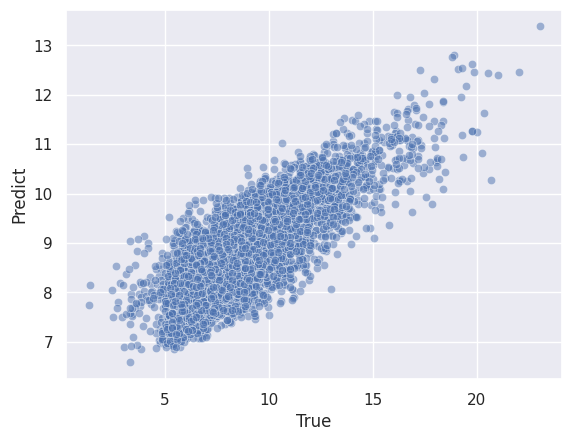

In [64]:
x_ntn, y_ntn = df_ntn.drop("ASI", axis=1), df_ntn["ASI"]

htn_sweep = wandb.Api().sweep("olink_asi_ntn/sh6dtmsj")
best_run = htn_sweep.best_run(order="r2")
model_ntn = train_xgb(x_ntn, y_ntn, best_run.config)

In [74]:
from sklearn.linear_model import LinearRegression

x_ntn.fillna(x_ntn.mean(), inplace=True)
x_ntn = (x_ntn - x_ntn.mean()) / x_ntn.std()

X_train, X_eval, y_train, y_eval = train_test_split(x_ntn, y_ntn, test_size=0.1, random_state=42)

estimator = LinearRegression()
estimator.fit(X_train, y_train)

estimator.score(X_eval, y_eval)

-1.2455267063740028

In [76]:
estimator.score(X_train, y_train)


0.648793828043597

np.float64(0.2927822666842049)

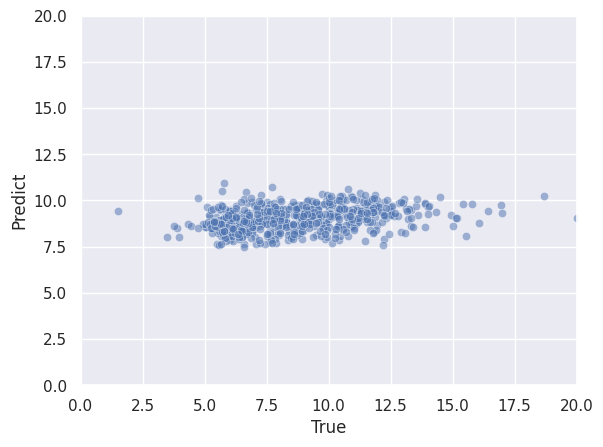

In [79]:
X_train, X_eval, y_train, y_eval = train_test_split(x_ntn, y_ntn, test_size=0.1, random_state=42)
ax = sns.scatterplot(x=y_eval, y=model_ntn.predict(X_eval), alpha=0.5)
ax.set(xlabel="True", ylabel="Predict", ylim=(0, 20), xlim=(0, 20))

#compute correlation
np.corrcoef(y_eval, model_ntn.predict(X_eval))[1, 0]


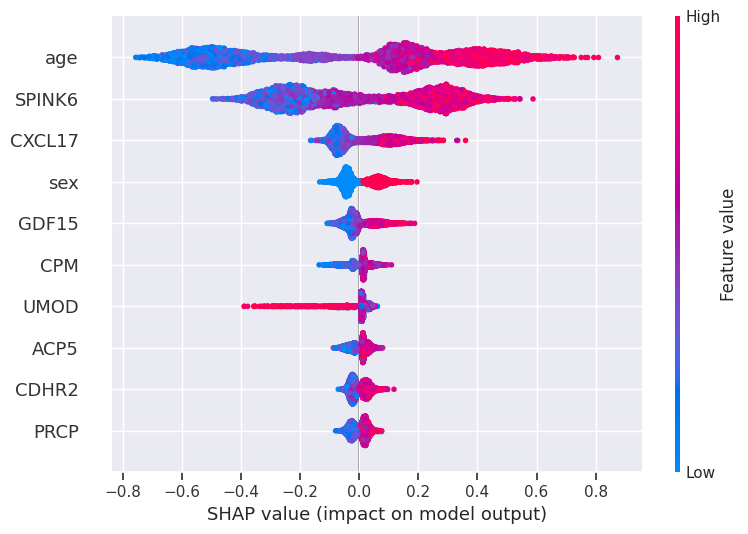

In [66]:
explainer = shap.TreeExplainer(model_ntn)
shap_values_ntn = explainer(x_ntn)
shap.summary_plot(shap_values_ntn, x_ntn, max_display=10)

27

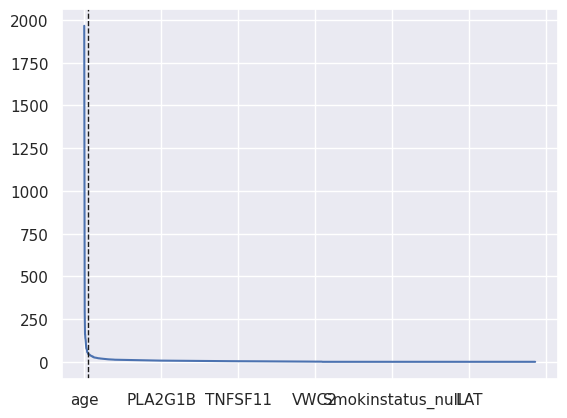

In [67]:
imps = shap_to_importance(shap_values_ntn, x_ntn.columns)
ntn_elbow = get_elbow_point(imps)
ntn_important_feats = imps[:ntn_elbow]
len(ntn_important_feats)

In [68]:
matteos_ntn_feats = set(
    pl.scan_csv(nb_data / "GLM Olink ASI ntn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("protein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_ntn = (matteos_ntn_feats & set(ntn_important_feats.index))
same_feats_ntn, len(same_feats_ntn)

({'ACP5',
  'ADGRG2',
  'CDHR2',
  'CPM',
  'CXCL17',
  'GDF15',
  'IGFBP1',
  'NOS3',
  'NPL',
  'PLAT',
  'PRCP',
  'SELE',
  'SPINK6',
  'SSC5D',
  'UMOD'},
 15)

### htn

wandb: Sorting runs by -summary_metrics.r2
/home/prenc/.miniconda3/envs/olink/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:40:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/prenc/.miniconda3/envs/olink/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:40:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:3.23751	validation_1-rmse:3.13936
[5]	validation_0-rmse:3.05242	validation_1-rmse:3.10164
[10]	validation_0-rmse:2.90438	validation_1-rmse:3.07812
[15]	validation_0-rmse:2.76677	validation_1-rmse:3.06059
[20]	validation_0-rmse:2.63934	validation_1-rmse:3.03412
[25]	validation_0-rmse:2.53174	validation_1-rmse:3.03681
[30]	validation_0-rmse:2.42012	validation_1-rmse:3.03306
[35]	validation_0-rmse:2.33485	validation_1-rmse:3.02985
[40]	validation_0-rmse:2.24884	validation_1-rmse:3.02801
[45]	validation_0-rmse:2.16916	validation_1-rmse:3.03040
[50]	validation_0-rmse:2.09375	validation_1-rmse:3.03371
[53]	validation_0-rmse:2.04886	validation_1-rmse:3.03480
Train R2: 0.5476 Eval R2: 0.0712


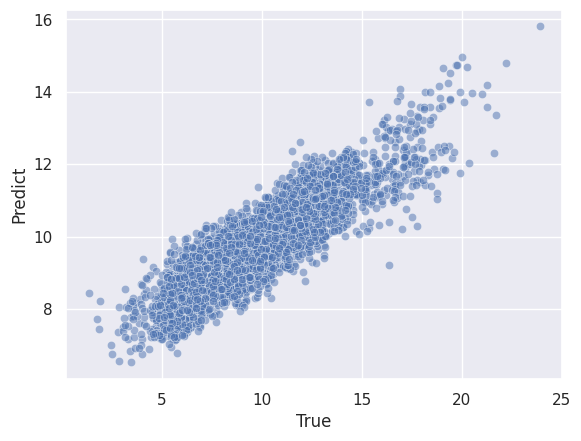

In [59]:
htn_sweep = wandb.Api().sweep("olink_asi_htn/mehz3cf5")
best_run = htn_sweep.best_run(order="r2")

x_htn, y_htn = df_htn.drop("ASI", axis=1), df_htn["ASI"]
model_htn = train_xgb(x_htn, y_htn, best_run.config)

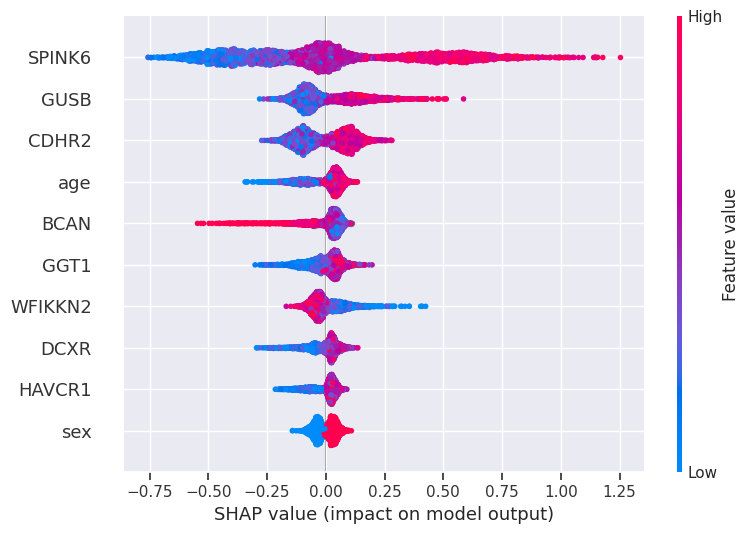

In [61]:
explainer = shap.TreeExplainer(model_htn)
shap_values_htn = explainer(x_htn)
shap.summary_plot(shap_values_htn, x_htn, max_display=10)

21

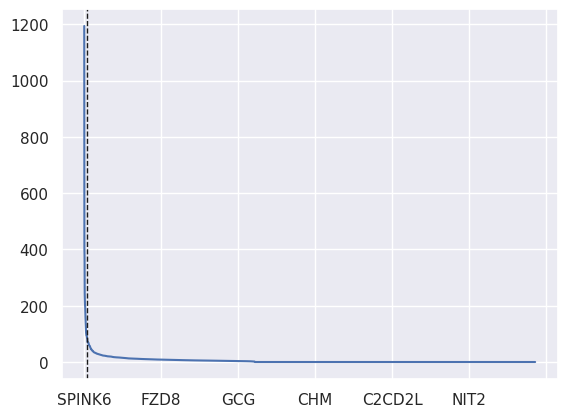

In [62]:
imps = shap_to_importance(shap_values_htn, x_htn.columns)
htn_elbow = get_elbow_point(imps)
htn_important_feats = imps[:htn_elbow]
len(htn_important_feats)

In [63]:
matteos_feats_htn = set(
    pl.scan_csv(nb_data / "GLM Olink ASI htn ZscoreAll.csv", skip_rows=1)
    .filter(pl.col("Sig.-adj FDR") <= 0.05)
    .select(pl.col("ptotein_name").str.split(";").list.first().alias("protein_name"))
    .collect()
    ["protein_name"]
    .to_list()
)

same_feats_htn = (matteos_feats_htn & set(htn_important_feats.index))
same_feats_htn, len(same_feats_htn)

({'ACE2',
  'ADGRD1',
  'APCS',
  'BCAN',
  'CDHR2',
  'DCXR',
  'GDF15',
  'GGT1',
  'GUSB',
  'HAVCR1',
  'HGF',
  'KITLG',
  'OPTC',
  'SPINK6',
  'WFIKKN2'},
 15)

## Wandb sweep

In [ ]:
from functools import partial
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import wandb


def eval_xgb(config, x, y):
    X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.1, random_state=42)

    estimator = XGBRegressor(
        n_estimators=config.n_estimators,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        gamma=config.gamma,
        min_child_weight=config.min_child_weight,
        reg_alpha=config.reg_alpha,
        reg_lambda=config.reg_lambda,
        tree_method="hist",
        device="gpu",
        random_state=42,
        early_stopping_rounds=10,
    )

    estimator.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=0)
    return estimator.score(X_eval, y_eval)


x_htn, y_htn = df_htn.drop("ASI", axis=1), df_htn["ASI"]
objective = partial(eval_xgb, x=x_htn, y=y_htn)


def main():
    wandb.init(project="olink_asi_htn")
    score = objective(wandb.config)
    wandb.log({"r2": score})


sweep_configurations = {
    "method": "bayes",
    "metric": {"name": "r2", "goal": "maximize"},
    "parameters": {
        'n_estimators': {'distribution': 'int_uniform', 'min': 50, 'max': 500},
        'max_depth': {'distribution': 'int_uniform', 'min': 1, 'max': 10},
        'learning_rate': {'distribution': 'log_uniform', 'min': 0.001, 'max': 0.1},
        'subsample': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'colsample_bytree': {'distribution': 'uniform', 'min': 0.5, 'max': 1.0},
        'gamma': {'distribution': 'uniform', 'min': 0, 'max': 10},
        'min_child_weight': {'distribution': 'int_uniform', 'min': 1, 'max': 20},
        'reg_alpha': {'distribution': 'log_uniform', 'min': 1e-5, 'max': 100},
        'reg_lambda': {'distribution': 'log_uniform', 'min': 1e-5, 'max': 100}
    },
}

sweep_id = wandb.sweep(sweep_configurations, project="olink_asi_htn")
sweep_id

In [ ]:
wandb.agent(sweep_id, function=main)